# Project : Wrangle OpenStreetMap Data (SQL)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#importmap">Map import</a></li>
<li><a href="#problem">Problems Encountered in the Maps</a></li>
<li><a href="#tosql">Transfer of cleaned data to csv files and then to SQL database</a></li>
<li><a href="#data">Data Overview</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#ref">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

I chose to work on the OpenStreetMap data from the city of Glasgow (Scotland). I also chose to perform the data wrangling with SQL.

<a id='importmap'></a>
## Map import

I used the Overpass-Api to import the map of Glasgow which returned a .osm file (arround 207 Mb uncompressed). The ***mapparser.py*** script returns the following number of tags in the .osm file :
```
{'note': 1,
 'meta': 1,
 'node': 874774,
 'tag': 499438,
 'nd': 1078128,
 'way': 143444,
 'member': 75860,
 'relation': 1340,
 'osm': 1}
```
We can recognize the type of top level tags that is given in the OpenStreetMap Wiki. I can also find that **1253** unique users have contributed to this map, using with the ***user.py*** script.

<a id='problem'></a>
## Problems encountered in the map



### Value types in the tags

The ***tags.py*** script returned the following number of "k" value type in the tags:
```
{'lower': 425110, 'lower_colon': 47979, 'problemchars': 0, 'other': 26349}
```
There are no problematic characters in the full file tags (that must be unusual !). Still, there are a lot of 'other' which may contain numbers, characters other than problematic, or several colons.

### Street names

The street name audit (***audit_streets.py***) returned some overabbreviated names like `Rd`, `St` or `Ave` and some typo errors like `Sreet`, `Strret`... I completed the street name mapping dictionnary to fix these names. The street name cleaning is performed using this function:

In [7]:
# Change a non-confrom street name to a conform one
def update_street_name(name, mapping_street):
    for old_name, new_name in mapping_street.items():
        if name.endswith(old_name):
            name = name.replace(old_name, new_name)
            break
    return name

The function returns names conform to the ones in the "expected" list.

### Postal codes

The script ***audit_addr.py*** returns the city and postal codes whenever the postal code does not match the dedicated regular expression `'[G]\d{1,2} \b\d[A-Z]{2,2}'`. The *audit_postal* function returned some results that does not match the regular expression like `('', 'G21')`, `('Renfrew', 'PA4 0AJ')` or `('Hamilton', 'ML3 0PX')`.
- Some cities are missing from nodes having a postal code,
- Some postal codes only contain the first 3 digits (but they match the 3 first digit of the regular expression),
- The cities name are not necessarily in the same format ('glasgow', 'GLASGOW', 'Glasgow').  

Apart from that, the postal codes that do not match our regular expression seem legitimate. `'PA'` postal codes are linked to the Renfrew city (where lies the Glasgow Airport). `'ML'` postal codes stand for Hamilton and Coatbridge cities. We can keep the postal codes as they are. However we can standardize the city names.

### City names

The *audit_city* function from ***audit_addr.py*** returned a set of every name stored in the *addr:city* tag of the map. By looking at them, these are suburbs, towns and villages in the vicinity of Glasgow as well as some inner Glasgow district names.  
The mapping will correct typo errors and replace the districts by the city they belong to. The mapping is done so that we will be able differenciate the inner Glasgow locations from the great Glasgow ones by keeping their suburban names.
 The city name updating uses a similar function than in street name audit script:

In [8]:
# Change a non-confrom city name to a conform one
def update_city_name(name, mapping_city):
    for old_name, new_name in mapping_city.items():
        if name == old_name:
            name = name.replace(old_name, new_name)
            break
    return name

The cleaned names of the cities correspond to:
- Glasgow for any inner area or district of Glasgow, or to
- The respective name of any neighbouring suburbs, towns or villages near Glasgow. 

<a id='tosql'></a>
## Transfer of cleaned data to csv files and then to SQL database

To generate the .csv files, we can use the script ***data_clean.py***. In this script, I imported the cleaning functions for street name and city names that we saw before. I used python 2 to run this script that used unicode instances.

After running the script on the sample osm file with the *process_map* function set to *validation = True*, the script returned no error. Then I ran the script on the full osm file which generated the expected csv files according to the schema.py script.

However, when importing the csv files into the SQL database tables using *sqlite3*, an error was raised on the FOREIGN KEYS constraints. By looking at the csv files using pandas dataframes, I noticed that some 'id' in *ways_nodes.csv* were not on the *nodes.csv* 'node_id'. This was confirmed when searching in the .osm file. Somes 'nd' references in way tags do not appear in the node tags. 

To solve this issue, I added a function *check_csv* to the script to identify missing value in a column that will be used as a foreign key, compared to the column that will be used as a reference key (according to the SQL schema). If rows are identified, the function drop them in the csv file.

In [36]:
# Script generating the csv files and fixing the compliance between foreign key columns and reference columns in the csv files
!python2 data_clean.py

No foreign key from nodes_tags.csv missing from nodes.csv
No foreign key from ways_tags.csv missing from ways.csv
No foreign key from ways_nodes.csv missing from ways.csv
foreign keys from ways_nodes.csv missing in nodes.csv 
  -> Droping orphan rows in ways_nodes.csv


The data is now clean and the dependencies between foreign keys and reference keys are fixed. I generated the SQL database tables according to the provided schema (this time without any errors). The intial osm file and sql database sizes are given below:
- glasgow.osm : 207.0 MB
- glasgow.db : 108.6 MB

<a id='data'></a>
## Data Exploration
To perform the data exploration, we are going to use SQL queries based on the python DB-API method calls. In order to have a better visibility, we can create a function that will execute the SQL queries and return a pandas dataframe (as SQL queries results are tables, a pandas dataframe is well suited).

In [2]:
# importing all necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Style and size of graph
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,6)})

In [3]:
def execute_query(QUERY, header):
    db = sqlite3.connect("glasgow.db")
    c = db.cursor()
    c.execute(QUERY)
    rows = c.fetchall()
    df = pd.DataFrame(rows, columns = header)
    db.close()
    return df

### Number of nodes and ways

In [17]:
QUERY = "SELECT COUNT(*) FROM nodes;"

execute_query(QUERY, ['count']).set_index([['nodes']])

,count
nodes,874774


In [18]:
QUERY = "SELECT COUNT(*) FROM ways;"

execute_query(QUERY, ['count']).set_index([['ways']])

,count
ways,143444


There are **874,774 nodes** and **143,444 ways**.

### TOP 10 contributing users
To perform this query, we can use the UNION ALL command to concatenate the queries of user selection from nodes and ways tables. We will group the result by user id rather than user names (in case several users have the same name).

In [19]:
QUERY = "SELECT user, COUNT(*) AS number \
FROM (SELECT user, uid FROM nodes UNION ALL SELECT user, uid FROM ways) \
GROUP BY uid \
ORDER BY number DESC \
LIMIT 10;"

execute_query(QUERY, ['user', 'number'])

,user,number
0,drnoble,185364
1,Scarlet72,100387
2,crossmyloof,73611
3,addavies,71844
4,Hawkeye,68446
5,cupofcoffee,68409
6,ClarkstonCorrect,65545
7,Ossian Lore,51298
8,marscot,33142
9,Central America,27740


Special mention for **drnoble** and **Scarlet72** for their amount of contributions.

### Number of places to eat or drink
We will restrict our analysis to restaurants, fast foods, pubs and cafe using the LIKE command to cover some potential differences of typos.

In [32]:
QUERY = "SELECT value, COUNT(*) AS number \
FROM (SELECT key, value FROM nodes_tags UNION ALL SELECT key, value FROM ways_tags) \
WHERE key = 'amenity' \
AND value LIKE 'restaurant' \
OR value LIKE 'fast%food' \
OR value LIKE 'pub' \
OR value LIKE 'cafe' \
GROUP BY value \
ORDER BY number DESC;"

execute_query(QUERY, ['type', 'number'])

,type,number
0,fast_food,412
1,restaurant,401
2,pub,358
3,cafe,333


### Number of bicycle amenities
We can find the number of amenities related to bicycles. This time we will restrict the choice to the keys equal to amenity and value containing the word 'bicylce' using the LIKE command.

In [21]:
QUERY = "SELECT value, COUNT(*) AS number \
FROM (SELECT key, value FROM nodes_tags UNION ALL SELECT key, value FROM ways_tags) \
WHERE key = 'amenity' AND value LIKE '%bicycle%'\
GROUP BY value \
ORDER BY number DESC \
LIMIT 10;"

execute_query(QUERY, ['type', 'number'])

,type,number
0,bicycle_parking,695
1,bicycle_rental,53
2,bicycle_repair_station,4


The number of bicycle parkings is quite high which is a good thing to improve the life quality in the city.

### TOP 10 popular cuisine

In [21]:
QUERY = "SELECT value, COUNT(*) AS number \
FROM (SELECT key, value FROM nodes_tags UNION ALL SELECT key, value FROM ways_tags) \
WHERE key = 'cuisine' \
GROUP BY value \
ORDER BY number DESC \
LIMIT 10;"

execute_query(QUERY, ['type', 'number'])

,type,number
0,chinese,89
1,indian,85
2,italian,60
3,coffee_shop,59
4,sandwich,59
5,burger,43
6,fish_and_chips,42
7,pizza,42
8,asian,27
9,regional,17


There are lots of **chinese** and **indian** food places which are indeed very popular in UK. There aren't many regional food places however.

### Location of bus stops
We can check where are the bus stops in Glasgow. To to that, we can join the tables *nodes* and *nodes_tag* to have the GPS coordinates ('lat', 'lon' in nodes) and filter these coordinates by *node_tags* values matching the bus stop typos.

Text(0, 0.5, 'Latitude (°)')

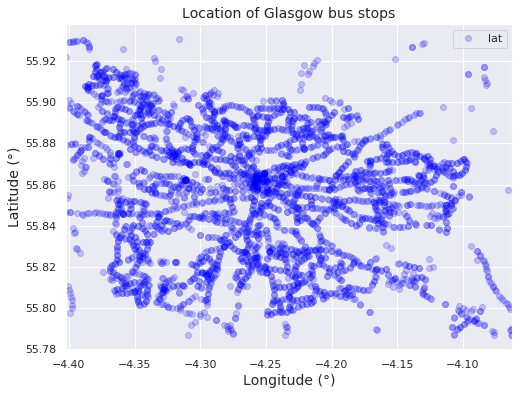

In [25]:
QUERY = "SELECT nodes.lat, nodes.lon, nodes_tags.value \
FROM nodes JOIN nodes_tags ON nodes.id = nodes_tags.id \
WHERE nodes_tags.value LIKE 'bus%stop';"

df_bus = execute_query(QUERY, ['lat', 'lon', 'value'])
# Plotting the results
df_bus.plot(x = 'lon', y = 'lat', style = 'o', c = 'blue', alpha = 0.2)
plt.title('Location of Glasgow bus stops', fontsize = 14)
plt.xlabel('Longitude (°)', fontsize = 14)
plt.ylabel('Latitude (°)', fontsize = 14)

We find a pattern well corresponding to the city roads including the suburbs.

### What and where are the differents cities ?
As we saw during data audit, there are different cities in our map. It would be interesting to locate the different cities on a map. To do that, we could estimate the center of each city by calculating the mean latitude and the mean longitude of all the nodes corresponding to this city.   
This rationnal is however limited by the number of actually (and correctly) identified nodes. If we suppose that there are sufficient relevant nodes per city, the result will be approximately the coordinates of the barycentre of the most concentrated nodes per city.    
We will return the result ordered by the count of each city occurrence.

In [15]:
QUERY = "SELECT value, AVG(lat) as mean_lat, AVG(lon) as mean_lon, COUNT(*) as number \
FROM (SELECT id, key, value FROM nodes_tags UNION ALL SELECT id, key, value FROM ways_tags) as all_tags \
JOIN nodes ON nodes.id = all_tags.id \
WHERE key = 'city' \
GROUP BY value \
ORDER BY number DESC;"

df_cities = execute_query(QUERY,['city', 'mean_lat', 'mean_lon', 'count'])
df_cities.head()

,city,mean_lat,mean_lon,count
0,Glasgow,55.862948,-4.259790,1594
1,Mount Ellen,55.896716,-4.091731,140
2,Gartcosh,55.893581,-4.079864,127
3,Clarkston,55.791223,-4.286300,16
4,Hamilton,55.822434,-4.204107,16


We can recognize the main towns and suburbs in the vicinity of Glasgow. Let's check the position of these points on a scatter graph. We can add a third dimension to take into account the occurence of each city in the dataframe.

(55.78, 55.94)

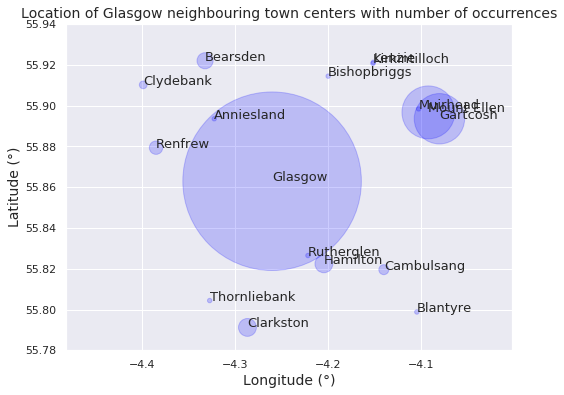

In [31]:
# Generating a scatter plot of coordinates
fig, ax = plt.subplots()
ax.scatter(df_cities['mean_lon'], df_cities['mean_lat'], s = df_cities['count']*20, c = 'blue', alpha = 0.2)
# Generating annotations
for i, txt in enumerate(df_cities['city']):
    ax.annotate(txt, (df_cities['mean_lon'][i], df_cities['mean_lat'][i]), size = 13)
# Graph features
plt.title('Location of Glasgow neighbouring town centers with number of occurrences', fontsize = 14)
plt.xlabel('Longitude (°)', fontsize = 14)
plt.ylabel('Latitude (°)', fontsize = 14)
plt.ylim(55.78, 55.94)

This correponds roughly to the center position of each neighbouring town that we can find on OpenStreetMap. Without surprise, Glasgow has the highest number of tags with city value filled.

<a id='conclusions'></a>
## Conclusion and additional ideas

The number of users that have contributed to this map (1253) is quite significant. It might explain the discrepancy and the missings in the tags fields. This study  highlighted the fact that, concerning data entry, the more it is humanized, the more scattered is the data. Nevertheless, added to the street and city names cleaning we performed, the data was still exploitable.

However the data cleaning we performed in our analysis is at most partial. Similar rational than the ones we used to clean street and city names could be perform for other amenities (food places, shops...). Some postal codes are not fully entered (although globaly compliant with the official full postal codes). To solve that, OpenStreetMap could rely more on GPS coordinates linked them to official postal code websites.

In order to improve the data cleanliness in OpenStreetMap, one way is to standardize data entries. This can be done by restricting entries only to approved words to avoid typo errors or wrong fields. The limitation of restraining entries to only approved words is that specific, new or unique names cannot be entered. We could even imagine an IA that could recognize most common errors and makes correction proposals to the user before implementing it in the database.  


<a id='ref'></a>
## References

Udacity Data Wrangling lessons python scripts samples

- https://www.openstreetmap.org/#map=12/55.8553/-4.2632
- https://wiki.openstreetmap.org/wiki/OSM_XML
- http://overpass-api.de/query_form.html
- https://wiki.openstreetmap.org/wiki/Overpass_API
- https://stackoverflow.com
- https://learnbyexample.github.io/cheatsheet/python/python-regex-cheatsheet/
- https://postal-code.co.uk/postcode/Glasgow
- https://en.wikipedia.org/wiki/
- https://stackoverflow.com/questions/6812031/how-to-make-unicode-string-with-python3
- https://www.w3schools.com/sql
- https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point